# train XGBosst and keep the model selection rank

In [1]:
#external libraries
import os
import dotenv
import pandas as pd
import numpy as np
from scipy import signal as sg
import pickle as pkl
import time
import matplotlib.pyplot as plt

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']

In [2]:
#define features path
dreamspath=datapath+"/DREAMS"
featurespath=dreamspath+"/features"
        
windowDurations=[0.5,1,1.5,2]

## Load data

In [3]:
signals, annotations, signalsMetadata = loadDREAMSSpindles(dreamspath)

SubjectId: 0001--------------
resampling from 100 to 200
SubjectId: 0003--------------
resampling from 50 to 200
SubjectId: 0006--------------
duration discrepancy, removing last 0.7 seconds


In [4]:
signalsMetadata

,filename,channel,subjectId,duration,samplerate,database
0,excerpt1.txt,C3-A1,0001,1800,200,DREAMS
1,excerpt2.txt,CZ-A1,0002,1800,200,DREAMS
2,excerpt3.txt,C3-A1,0003,1800,200,DREAMS
3,excerpt4.txt,CZ-A1,0004,1800,200,DREAMS
4,excerpt5.txt,CZ-A1,0005,1800,200,DREAMS
5,excerpt6.txt,CZ-A1,0006,1800,200,DREAMS
6,excerpt7.txt,CZ-A1,0007,1800,200,DREAMS
7,excerpt8.txt,CZ-A1,0008,1800,200,DREAMS


## Load features

In [5]:
windowDurations

[0.5, 1, 1.5, 2]

In [6]:
featureDf=pd.DataFrame()

durationFolders=os.listdir(dreamspath+'/features/200fs')
for duration in durationFolders:
    subjectFolders=os.listdir(dreamspath+'/features/200fs/'+duration)
    for subject in subjectFolders:
        aux=os.listdir(dreamspath+'/features/200fs/'+duration+'/'+subject)
        thisFeatureDf=pd.DataFrame({
            'filename':aux
        })
        featureDf=pd.concat([featureDf,thisFeatureDf],axis=0)

In [7]:
featureDf

,filename
0,0.5_0001_hjortActivity_alpha.fd
1,0.5_0001_hjortActivity_beta1.fd
2,0.5_0001_hjortActivity_beta2.fd
3,0.5_0001_hjortActivity_broadband.fd
4,0.5_0001_hjortActivity_delta1.fd
...,...
28,2_0008_petrosian_delta1.fd
29,2_0008_petrosian_delta2.fd
30,2_0008_petrosian_sigma.fd
31,2_0008_petrosian_theta.fd


In [8]:
featureDf['window']=featureDf.apply(lambda row:
                                    row.filename.split('_')[0],axis=1)
featureDf['subjectId']=featureDf.apply(lambda row:
                                    row.filename.split('_')[1],axis=1)
featureDf['characteristic']=featureDf.apply(lambda row:
                                    row.filename.split('_')[2],axis=1)
featureDf['bandName']=featureDf.apply(lambda row:
                                    row.filename.split('_')[3].split('.')[0],axis=1)

In [9]:
featureDf

,filename,window,subjectId,characteristic,bandName
0,0.5_0001_hjortActivity_alpha.fd,0.5,0001,hjortActivity,alpha
1,0.5_0001_hjortActivity_beta1.fd,0.5,0001,hjortActivity,beta1
2,0.5_0001_hjortActivity_beta2.fd,0.5,0001,hjortActivity,beta2
3,0.5_0001_hjortActivity_broadband.fd,0.5,0001,hjortActivity,broadband
4,0.5_0001_hjortActivity_delta1.fd,0.5,0001,hjortActivity,delta1
...,...,...,...,...,...
28,2_0008_petrosian_delta1.fd,2,0008,petrosian,delta1
29,2_0008_petrosian_delta2.fd,2,0008,petrosian,delta2
30,2_0008_petrosian_sigma.fd,2,0008,petrosian,sigma
31,2_0008_petrosian_theta.fd,2,0008,petrosian,theta


In [10]:
uniqueFeature=featureDf[['window','characteristic','bandName']].drop_duplicates(ignore_index=True)

In [11]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,database
0,excerpt1.txt,C3-A1,0001,1800,200,DREAMS
1,excerpt2.txt,CZ-A1,0002,1800,200,DREAMS
2,excerpt3.txt,C3-A1,0003,1800,200,DREAMS
3,excerpt4.txt,CZ-A1,0004,1800,200,DREAMS
4,excerpt5.txt,CZ-A1,0005,1800,200,DREAMS


In [12]:
uniqueFeature

,window,characteristic,bandName
0,0.5,hjortActivity,alpha
1,0.5,hjortActivity,beta1
2,0.5,hjortActivity,beta2
3,0.5,hjortActivity,broadband
4,0.5,hjortActivity,delta1
...,...,...,...
127,2,petrosian,delta1
128,2,petrosian,delta2
129,2,petrosian,sigma
130,2,petrosian,theta


## do a training

In [13]:
samplerate=200
featureSelection=uniqueFeature.copy()
labelerIdList=['0001','0002']
train=np.array(signalsMetadata.subjectId)


In [14]:
n_jobs=4 # paralelization parameter for xgboost (keep it 8 as maximum)
learning_rate=0.4
#subsample=0.6
subsample=0.1

num_boost_round=30  #number of boosting rounds per model
n_bootstraps=1000

models=[]
modelIds=[]
valF1s=[]
spindleTimeRates=[]
    
#Define annotations criterium
usedAnnotations=annotations[annotations.labelerId.isin(labelerIdList)].reset_index(drop=True)
#Features
trainFeatures=loadFeatureMatrix(train,featureSelection,signalsMetadata,samplerate,datapath)

#Labels
trainLabels=loadLabelsVector(train,usedAnnotations,signalsMetadata,samplerate)




uniqueFeature['Times_selected']=np.zeros((uniqueFeature.shape[0],))
uniqueFeature['index']=np.arange(uniqueFeature.shape[0],)
scores_ratio=np.zeros((uniqueFeature.shape[0], n_bootstraps))

for i in range(n_bootstraps):
    print('Iteration '+str(i)+' out of '+str(n_bootstraps))
    #Train the models
    params={
        'n_jobs':n_jobs,
        'learning_rate':learning_rate,
        'random_state':i+100,
        'subsample':subsample,
        'objective':'binary:logistic'
    }
    trainDMatrix=xgb.DMatrix(data=trainFeatures,label=trainLabels)
    xgb_model = xgb.train(params,trainDMatrix,num_boost_round=num_boost_round, xgb_model=None)
    
    
    aux=xgb_model.get_score()
    scores=np.zeros((uniqueFeature.shape[0],))
    for name,val in aux.items():
        scores[int(name.split('f')[1])]=val
    uniqueFeature['score'] = scores
    totalScore=np.sum(uniqueFeature.score)
    scores_ratio[:,i]=scores/totalScore
    scores_sort=np.flip(np.sort(scores))
    order=np.cumsum(np.flip(np.sort(scores)))/np.sum(scores)
    uniqueFeature=uniqueFeature.sort_values('score',ascending=False)
    N_feat=np.argwhere(order>0.5)[0][0]
    thx_score=scores_sort[N_feat]
    print('Number of selected features: '+str(N_feat))
    uniqueFeature.loc[scores_sort>=thx_score,'Times_selected']+=1
    uniqueFeature=uniqueFeature.sort_values('index',ascending=True)


Iteration 0 out of 1000
Number of selected features: 25
Iteration 1 out of 1000
Number of selected features: 26
Iteration 2 out of 1000
Number of selected features: 27
Iteration 3 out of 1000
Number of selected features: 25
Iteration 4 out of 1000
Number of selected features: 26
Iteration 5 out of 1000
Number of selected features: 27
Iteration 6 out of 1000
Number of selected features: 26
Iteration 7 out of 1000
Number of selected features: 25
Iteration 8 out of 1000
Number of selected features: 26
Iteration 9 out of 1000
Number of selected features: 25
Iteration 10 out of 1000
Number of selected features: 24
Iteration 11 out of 1000
Number of selected features: 25
Iteration 12 out of 1000
Number of selected features: 26
Iteration 13 out of 1000
Number of selected features: 26
Iteration 14 out of 1000
Number of selected features: 26
Iteration 15 out of 1000
Number of selected features: 25
Iteration 16 out of 1000
Number of selected features: 26
Iteration 17 out of 1000
Number of select

In [22]:
uniqueFeature=uniqueFeature.drop(['index', 'score'], axis=1)
uniqueFeature.sort_values('Times_selected',ascending=False)


,window,characteristic,bandName,Times_selected
131,2,sigmaIndex,broadband,1000.0
105,2,hjortActivity,sigma,1000.0
65,1.5,sigmaIndex,broadband,1000.0
72,1,hjortActivity,sigma,1000.0
98,1,sigmaIndex,broadband,1000.0
...,...,...,...,...
20,0.5,hjortMobility,delta1,0.0
64,1.5,petrosian,theta,0.0
63,1.5,petrosian,sigma,0.0
62,1.5,petrosian,delta2,0.0


In [23]:
dumpPickle("featureSelectionComplete_bootstrapppingR2.pkl",uniqueFeature)
dumpPickle("allscores_featureSelection_bootstrapppingR2.pkl",scores_ratio)

C:\Users\GIB\AppData\Local\Temp\ipykernel_19216\2228430520.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


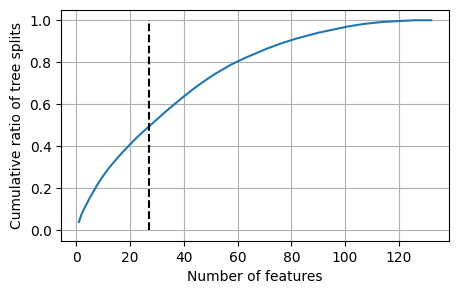

In [24]:
fig=plt.figure()
plt.plot(np.arange(uniqueFeature.shape[0])+1,order)
plt.grid()
plt.vlines(x=[27],ymin=[0],ymax=[1],colors=['black'],linestyles=['dashed'],label="27 features")
plt.xlabel("Number of features")
plt.ylabel("Cumulative ratio of tree splits")
fig.set_size_inches(5, 3)
fig.show()
plt.savefig('Feature_selection_overview.png',bbox_inches='tight', dpi=600, format="png") 

In [26]:
##Save features selected in more than 750 bootstrapping iterations
tosave=uniqueFeature.sort_values('Times_selected',ascending=False).head(19).copy().reset_index(drop=True)
print(tosave)
dumpPickle("featureSelection_750bootstraping_iterations.pkl",tosave)



   window characteristic   bandName  Times_selected
0       2     sigmaIndex  broadband          1000.0
1       2  hjortActivity      sigma          1000.0
2     1.5     sigmaIndex  broadband          1000.0
3       1  hjortActivity      sigma          1000.0
4       1     sigmaIndex  broadband          1000.0
5       2  hjortActivity      beta1          1000.0
6       2  hjortActivity      beta2          1000.0
7     1.5  hjortActivity      sigma           999.0
8       2  hjortMobility      beta1           994.0
9       2  hjortActivity     delta2           986.0
10      2  hjortActivity  broadband           985.0
11      2  hjortMobility      sigma           975.0
12      2  hjortActivity      alpha           971.0
13    1.5  hjortActivity      beta2           918.0
14    0.5     sigmaIndex  broadband           899.0
15      2  hjortMobility      beta2           897.0
16      2  hjortMobility      alpha           893.0
17      2  hjortMobility     delta1           838.0
18    1.5  h

In [27]:
##Save features selected in more than 500 bootstrapping iterations
tosave=uniqueFeature.sort_values('Times_selected',ascending=False).head(26).copy().reset_index(drop=True)
print(tosave)
dumpPickle("featureSelection_500bootstraping_iterations.pkl",tosave)

   window characteristic   bandName  Times_selected
0       2     sigmaIndex  broadband          1000.0
1       2  hjortActivity      sigma          1000.0
2     1.5     sigmaIndex  broadband          1000.0
3       1  hjortActivity      sigma          1000.0
4       1     sigmaIndex  broadband          1000.0
5       2  hjortActivity      beta1          1000.0
6       2  hjortActivity      beta2          1000.0
7     1.5  hjortActivity      sigma           999.0
8       2  hjortMobility      beta1           994.0
9       2  hjortActivity     delta2           986.0
10      2  hjortActivity  broadband           985.0
11      2  hjortMobility      sigma           975.0
12      2  hjortActivity      alpha           971.0
13    1.5  hjortActivity      beta2           918.0
14    0.5     sigmaIndex  broadband           899.0
15      2  hjortMobility      beta2           897.0
16      2  hjortMobility      alpha           893.0
17      2  hjortMobility     delta1           838.0
18    1.5  h

In [28]:
##Save features selected in more than 250 bootstrapping iterations
tosave=uniqueFeature.sort_values('Times_selected',ascending=False).head(36).copy().reset_index(drop=True)
print(tosave)
dumpPickle("featureSelection_250bootstraping_iterations.pkl",tosave)


   window   characteristic   bandName  Times_selected
0       2       sigmaIndex  broadband          1000.0
1       2    hjortActivity      sigma          1000.0
2     1.5       sigmaIndex  broadband          1000.0
3       1    hjortActivity      sigma          1000.0
4       1       sigmaIndex  broadband          1000.0
5       2    hjortActivity      beta1          1000.0
6       2    hjortActivity      beta2          1000.0
7     1.5    hjortActivity      sigma           999.0
8       2    hjortMobility      beta1           994.0
9       2    hjortActivity     delta2           986.0
10      2    hjortActivity  broadband           985.0
11      2    hjortMobility      sigma           975.0
12      2    hjortActivity      alpha           971.0
13    1.5    hjortActivity      beta2           918.0
14    0.5       sigmaIndex  broadband           899.0
15      2    hjortMobility      beta2           897.0
16      2    hjortMobility      alpha           893.0
17      2    hjortMobility  

In [29]:
##Save features selected in more than 900 bootstrapping iterations
tosave=uniqueFeature.sort_values('Times_selected',ascending=False).head(14).copy().reset_index(drop=True)
print(tosave)
dumpPickle("featureSelection_900bootstraping_iterations.pkl",tosave)

   window characteristic   bandName  Times_selected
0       2     sigmaIndex  broadband          1000.0
1       2  hjortActivity      sigma          1000.0
2     1.5     sigmaIndex  broadband          1000.0
3       1  hjortActivity      sigma          1000.0
4       1     sigmaIndex  broadband          1000.0
5       2  hjortActivity      beta1          1000.0
6       2  hjortActivity      beta2          1000.0
7     1.5  hjortActivity      sigma           999.0
8       2  hjortMobility      beta1           994.0
9       2  hjortActivity     delta2           986.0
10      2  hjortActivity  broadband           985.0
11      2  hjortMobility      sigma           975.0
12      2  hjortActivity      alpha           971.0
13    1.5  hjortActivity      beta2           918.0


In [30]:
##Save features selected in more than 100 bootstrapping iterations
tosave=uniqueFeature.sort_values('Times_selected',ascending=False).head(45).copy().reset_index(drop=True)
print(tosave)
dumpPickle("featureSelection_100bootstraping_iterations.pkl",tosave)

   window   characteristic   bandName  Times_selected
0       2       sigmaIndex  broadband          1000.0
1       2    hjortActivity      sigma          1000.0
2     1.5       sigmaIndex  broadband          1000.0
3       1    hjortActivity      sigma          1000.0
4       1       sigmaIndex  broadband          1000.0
5       2    hjortActivity      beta1          1000.0
6       2    hjortActivity      beta2          1000.0
7     1.5    hjortActivity      sigma           999.0
8       2    hjortMobility      beta1           994.0
9       2    hjortActivity     delta2           986.0
10      2    hjortActivity  broadband           985.0
11      2    hjortMobility      sigma           975.0
12      2    hjortActivity      alpha           971.0
13    1.5    hjortActivity      beta2           918.0
14    0.5       sigmaIndex  broadband           899.0
15      2    hjortMobility      beta2           897.0
16      2    hjortMobility      alpha           893.0
17      2    hjortMobility  